In [1]:
import ctypes
import sys
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
os.system("cd cpp_code; make DSS")
lib=ctypes.CDLL("./cpp_code/DSS.so")

In [3]:
#a_initial = 0.00025
a_initial = 0.000025
a_final = 1.01

initialise_new_Universe_with_Matter_content = lib.initialise_new_Universe_with_Matter_content
# initialise_new_Universe_with_Matter_content          (double a_initial,  double a_final,  double Omega_m,  double Omega_b,  double Omega_r,  double Omega_L,  double sigma_8,      double n_s,    double h_100,       double w0,       double w1)
initialise_new_Universe_with_Matter_content.argtypes = [ ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]

# Cosmology of Quijote sims
#Omfid = 0.3175
#Obfid = 0.049
#hfid = 0.6711
#nsfid = 0.9624
#sig8fid = 0.834


# Cosmology of Marc's sims
Omfid = 0.25
Obfid = 0.04
hfid = 0.7
nsfid = 1.0
sig8fid = 0.8
z=0.9744

initialise_new_Universe_with_Matter_content(a_initial, a_final, Omfid, Obfid, 0.0, 1.0-Omfid, sig8fid, nsfid, hfid, -1.0, 0.0)


775

In [4]:

# N_delta has to be hardcoded, because is it needed for defining the python-c++ interface
N_delta = 1000
delta_min = -0.7
delta_max = 1.0

return_PDF = lib.return_PDF_2D
# return_PDF_2D       (                   double* delta_values,                                      double* PDF,  int n_delta, double delta_min, double delta_max,        double z, double R_in_comoving_Mpc, double L_in_comoving_Mpc,     double f_NL, double var_NL_rescale, int index_of_universe)
return_PDF.argtypes = [ctypes.POINTER(ctypes.c_double*N_delta),          ctypes.POINTER(ctypes.c_double*N_delta), ctypes.c_int,  ctypes.c_double,  ctypes.c_double, ctypes.c_double,          ctypes.c_double,          ctypes.c_double, ctypes.c_double,       ctypes.c_double,          ctypes.c_int]

## This function returns the probability distribution function (PDF) of the 3D matter density field
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe
def PDF_from_inv_Laplace_transform(z, R, L, f_NL, var_NL_rescale, index_of_universe):
    delta_values     = (ctypes.c_double*N_delta)()
    PDF_values       = (ctypes.c_double*N_delta)()
    return_PDF(ctypes.byref(delta_values), ctypes.byref(PDF_values),N_delta, delta_min, delta_max , z, R, L, f_NL, var_NL_rescale, index_of_universe)
    return np.array(delta_values), np.array(PDF_values)



In [17]:
delta_values, PDF_values = PDF_from_inv_Laplace_transform(z, 15.0, 200.0, 0.0, 0.940271345803, 0)

In [18]:
data_marc_Gaussian = np.loadtxt("../Density_Split_Statistics/data_for_2D_PNG_paper/Gaussian_sim_Marc_PDF_compensated_tsc_R15_L200.dat")

delta_marc = 0.5*(data_marc_Gaussian[:,0]+data_marc_Gaussian[:,1])-1.0
p_marc = data_marc_Gaussian[:,2]

p_marc = np.interp(delta_values, delta_marc, p_marc)
delta_marc = delta_values

In [19]:
ddelta=delta_values[1]-delta_values[0]
print np.sum(ddelta*PDF_values*delta_values**0),np.sum(ddelta*PDF_values*delta_values**1),np.sum(ddelta*PDF_values*delta_values**2)
#ddelta=delta_marc[1]-delta_marc[0]
print np.sum(ddelta*p_marc*delta_marc**0),np.sum(ddelta*p_marc*delta_marc**1),np.sum(ddelta*p_marc*delta_marc**2)


1.0000360933492916 0.00010492188166640048 0.018339592185493213
0.9999997861853692 -2.8595590870206244e-07 0.01833912106764138


In [16]:
print 0.01833912106764138/0.019504073105601302

0.940271345803


(-0.5, 0.7)

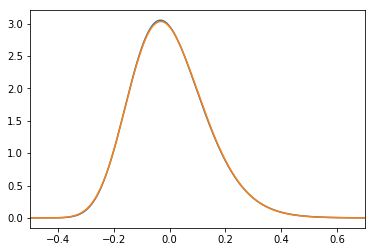

In [20]:
plt.plot(delta_values, PDF_values)
plt.plot(delta_marc, p_marc)
plt.xlim(-0.5, 0.7)

(-0.02, 0.02)

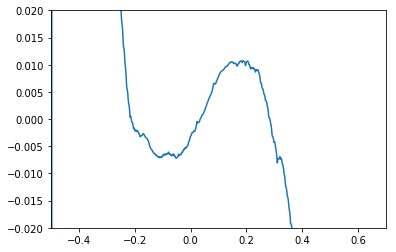

In [23]:
plt.plot(delta_values, p_marc/PDF_values-1.0)
plt.xlim(-0.5, 0.7)
plt.ylim(-0.02, 0.02)

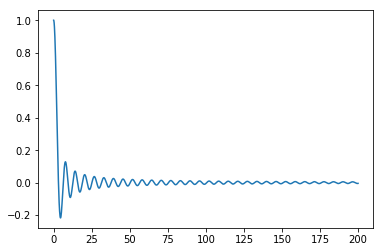

In [26]:
x = np.arange(0.001, 200.0, 0.1)
plt.plot(x, np.sin(x)/x)